In [1]:
import pandas as pd

In [2]:
df1=pd.read_csv('api_data_aadhar_biometric_0_500000.csv')

In [3]:
df1.sample(10)

,date,state,district,pincode,bio_age_5_17,bio_age_17_
130210,01-09-2025,Odisha,Rayagada,765019,10,9
71838,01-06-2025,Assam,Barpeta,781313,179,79
57880,01-05-2025,Andhra Pradesh,Chittoor,517112,253,98
253366,08-09-2025,Kerala,Pathanamthitta,691530,0,2
375208,13-09-2025,Tamil Nadu,Tiruppur,642126,9,8
38196,01-04-2025,Odisha,Nayagarh,752063,259,359
111542,01-09-2025,Andhra Pradesh,Parvathipuram Manyam,532456,1,0
189252,04-09-2025,Haryana,Jhajjar,124201,4,7
295003,10-09-2025,Jharkhand,Deoghar,814146,14,20
473767,18-09-2025,Bihar,Purnea,854326,1,3


In [4]:
files=[ "api_data_aadhar_biometric_0_500000.csv",
    "api_data_aadhar_biometric_500000_1000000.csv",
    "api_data_aadhar_biometric_1000000_1500000.csv",
    "api_data_aadhar_biometric_1500000_1861108.csv"]

In [5]:
df_list=[pd.read_csv(file) for file in files]
biometric_df=pd.concat(df_list,ignore_index=True)

In [6]:
print(biometric_df.shape)

(1861108, 6)


LOCATION PRESENT BUT bio_age_5_17 & bio_age_17 are 0

This might indicate---->
i.   Failed biometric capture
ii.  Enrollment session aborted
iii. Placeholder records inserted by the system

In [7]:

zero_bio_valid_location = biometric_df[
    (biometric_df['bio_age_5_17'] == 0) &
    (biometric_df['bio_age_17_'] == 0)
]

zero_bio_valid_location.head()


,date,state,district,pincode,bio_age_5_17,bio_age_17_
179473,04-09-2025,Karnataka,Belagavi,591220,0,0
180011,04-09-2025,Karnataka,Belagavi,591220,0,0
204209,05-09-2025,Andhra Pradesh,Tirupati,517102,0,0
228413,06-09-2025,Telangana,Jangoan,506316,0,0
304353,10-09-2025,Telangana,Jagitial,505529,0,0


Adult Biometrics Without Minor Biometrics
This might indicate---->
i.   Lower Aadhaar penetration among minors
ii.  Parental consent barriers
iii. Policy-driven enrolment focus on adults

In [8]:
adult_only = biometric_df[
    (biometric_df['bio_age_17_'] > 0) &
    (biometric_df['bio_age_5_17'] == 0)
]

adult_only.groupby('state').size().sort_values(ascending=False)


state
Andhra Pradesh                              36250
West Bengal                                 33861
Karnataka                                   26869
Kerala                                      23634
Tamil Nadu                                  22643
Maharashtra                                 19478
Gujarat                                     17176
Odisha                                      12083
Punjab                                      10525
Uttar Pradesh                                9414
Bihar                                        8775
Telangana                                    8268
Orissa                                       8237
Madhya Pradesh                               6910
Jharkhand                                    5940
Assam                                        5584
Himachal Pradesh                             5431
Rajasthan                                    5200
Chhattisgarh                                 4148
Uttarakhand                                 

Unusually High Biometric Values

This might indicate---->
i.   Bulk enrolment drives
ii.  Delayed batch uploads
iii. Aggregation errors at reporting level

In [9]:
biometric_df[['bio_age_5_17', 'bio_age_17_']].describe()
high_outliers = biometric_df[biometric_df['bio_age_17_'] > biometric_df['bio_age_17_'].quantile(0.99)]
high_outliers.sample(100)


,date,state,district,pincode,bio_age_5_17,bio_age_17_
76596,01-06-2025,Maharashtra,Jalgaon,425201,568,838
5100,01-03-2025,Karnataka,Ramanagar,562159,237,445
79908,01-06-2025,Maharashtra,Parbhani,431536,204,439
34466,01-04-2025,Jammu and Kashmir,Kupwara,193223,520,833
97926,01-07-2025,Rajasthan,Tonk,304025,377,352
...,...,...,...,...,...,...
68189,01-06-2025,Madhya Pradesh,Chhindwara,480221,591,847
12953,01-03-2025,Tamil Nadu,Erode,638002,262,475
14630,01-03-2025,Haryana,Karnal,132117,145,569
61651,01-05-2025,Maharashtra,Pune,411033,745,833


Same Pincode Appearing in Multiple States

In [10]:
pincode_state_conflict = (
    biometric_df.groupby('pincode')['state']
    .nunique()
    .reset_index()
)

conflicting_pincodes = pincode_state_conflict[
    pincode_state_conflict['state'] > 1
]

conflicting_pincodes.head()


,pincode,state
425,140308,2
438,140603,2
443,140901,2
920,160003,2
925,160014,2


Sudden Spikes and Drops in Daily Biometrics

<Axes: title={'center': 'Daily Biometric Enrolment Trend'}, xlabel='date'>

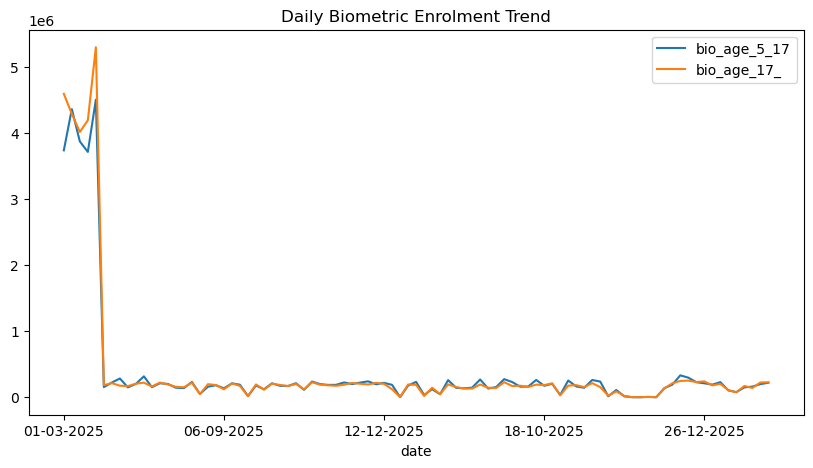

In [11]:
daily_biometrics = biometric_df.groupby('date')[['bio_age_5_17', 'bio_age_17_']].sum()

daily_biometrics.plot(figsize=(10,5), title="Daily Biometric Enrolment Trend")


RANKING OF THE ANOMALIES BY SEVERITY

----------------------------------------LEVEL 1(CRITICAL)--------------------------------------
1. Invalid Geographic Mapping (Pincode–State Conflict) (This breaks the geographical integrity)



----------------------------------------LEVEL 2(HIGH)--------------------------------------
1. Both age-group biometric counts are zero despite valid date and location.
2. Unusually high biometric values for a single district/day.


----------------------------------------LEVEL 3(MODERATE)--------------------------------------
1. Adult-Only Biometric Enrolment
2. Temporal Spikes and Drops


In [12]:
biometric_df.shape
#(1861108, 6)

(1861108, 6)

In [13]:
biometric_df.columns
#Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_'], dtype='object')

Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_'], dtype='object')

In [14]:
biometric_df.dtypes

'''
date            object
state           object
district        object
pincode          int64
bio_age_5_17     int64
bio_age_17_      int64
dtype: object
'''

'\ndate            object\nstate           object\ndistrict        object\npincode          int64\nbio_age_5_17     int64\nbio_age_17_      int64\ndtype: object\n'

In [15]:
total_duplicates = biometric_df.duplicated().sum()
total_duplicates

#94896

np.int64(94896)

In [16]:
biometric_df[biometric_df.duplicated()].head()


,date,state,district,pincode,bio_age_5_17,bio_age_17_
110000,01-09-2025,Chhattisgarh,Kondagaon,494229,0,1
110001,01-09-2025,Chhattisgarh,Kondagaon,494230,1,0
110002,01-09-2025,Chhattisgarh,Korba,495119,5,35
110003,01-09-2025,Chhattisgarh,Korba,495446,0,16
110004,01-09-2025,Chhattisgarh,Korba,495674,10,34


In [17]:
zero_5_17 = (biometric_df['bio_age_5_17'] == 0).sum()      #287670
zero_17_plus = (biometric_df['bio_age_17_'] == 0).sum()    #196095

zero_5_17, zero_17_plus

(np.int64(287670), np.int64(196095))

In [18]:
pd.to_datetime(biometric_df['date']).min(), pd.to_datetime(biometric_df['date']).max()



'''
    While running this , it was found that the data contains inconsistent date format
        like some are MM-DD-YYYY , some are DD-MM-YYYY
'''

ValueError: time data "13-09-2025" doesn't match format "%m-%d-%Y", at position 17. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
parsed_dates = pd.to_datetime(
    biometric_df['date'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
)

parsed_dates.min(), parsed_dates.max()

#Timestamp('2025-03-01 00:00:00'), Timestamp('2025-12-29 00:00:00')

In [ ]:
invalid_dates = parsed_dates.isna().sum()
invalid_dates

In [ ]:
parsed_dates.value_counts().head()


Number of Unique States, Districts & Pincodes

In [ ]:
print(biometric_df['state'].nunique())      #57
print(biometric_df['district'].nunique())   #974
print(biometric_df['pincode'].nunique())    #1907


No of pincodes per district

In [ ]:
pincode_per_district=(biometric_df.groupby(['state','district'])['pincode'].nunique().reset_index(name='pincode_count'))

pincode_per_district

In [ ]:
pincode_per_district.sort_values('pincode_count', ascending=False).head(10)

CREATING OF FINAL DATASET

In [19]:
biometric_df.to_csv("aadhaar_biometric_final.csv",index=False)

In [26]:
biometric_final_df=pd.read_csv('aadhaar_biometric_final.csv')
demographic_final_df=pd.read_csv('aadhaar_demographic_final.csv')
enrolment_final_df=pd.read_csv('aadhaar_enrolment_final.csv')

In [27]:
print(biometric_final_df.shape)
print(demographic_final_df.shape)
print(enrolment_final_df.shape)

(1861108, 6)
(1291855, 6)
(1006029, 7)


In [28]:
biometric_final_df.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,01-03-2025,Haryana,Mahendragarh,123029,280,577
1,01-03-2025,Bihar,Madhepura,852121,144,369
2,01-03-2025,Jammu and Kashmir,Punch,185101,643,1091
3,01-03-2025,Bihar,Bhojpur,802158,256,980
4,01-03-2025,Tamil Nadu,Madurai,625514,271,815


In [29]:
demographic_final_df.head()

,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,2025-03-01,Uttar Pradesh,Gorakhpur,273213,49,529
1,2025-03-01,Andhra Pradesh,Chittoor,517132,22,375
2,2025-03-01,Gujarat,Rajkot,360006,65,765
3,2025-03-01,Andhra Pradesh,Srikakulam,532484,24,314
4,2025-03-01,Rajasthan,Udaipur,313801,45,785


In [30]:
enrolment_final_df.head()

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21


In [31]:
biometric_final_df.columns

Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_'], dtype='object')

In [32]:
demographic_final_df.columns

Index(['date', 'state', 'district', 'pincode', 'demo_age_5_17',
       'demo_age_17_'],
      dtype='object')

In [33]:
enrolment_final_df.columns

Index(['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17',
       'age_18_greater'],
      dtype='object')

In [34]:
for df in [biometric_final_df, demographic_final_df, enrolment_final_df]:
    df['join_date'] = pd.to_datetime(
        df['date'],
        format='mixed',
        dayfirst=True,
        errors='coerce'
    )


In [35]:
bio_demo_df = pd.merge(
    biometric_final_df,
    demographic_final_df,
    on=['join_date', 'state', 'district', 'pincode'],
    how='outer',
    suffixes=('_bio', '_demo')
)

In [36]:
bio_demo_df.head()

,date_bio,state,district,pincode,bio_age_5_17,bio_age_17_,join_date,date_demo,demo_age_5_17,demo_age_17_
0,01-03-2025,Andaman & Nicobar Islands,Andamans,744101,16.0,193.0,2025-03-01,NaN,NaN,NaN
1,01-03-2025,Andaman and Nicobar Islands,Nicobar,744301,101.0,48.0,2025-03-01,2025-03-01,16.0,180.0
2,01-03-2025,Andaman and Nicobar Islands,Nicobar,744302,15.0,12.0,2025-03-01,NaN,NaN,NaN
3,01-03-2025,Andaman and Nicobar Islands,Nicobar,744303,46.0,27.0,2025-03-01,NaN,NaN,NaN
4,01-03-2025,Andaman and Nicobar Islands,Nicobar,744304,16.0,14.0,2025-03-01,NaN,NaN,NaN


In [37]:
final_df = pd.merge(
    bio_demo_df,
    enrolment_final_df,
    on=['join_date', 'state', 'district', 'pincode'],
    how='outer',
    suffixes=('', '_enr')
)


In [38]:
final_df['date_final'] = (
    final_df['date_bio']
    .combine_first(final_df['date_demo'])
    .combine_first(final_df['date'])
)


In [39]:
final_df.head()

,date_bio,state,district,pincode,bio_age_5_17,bio_age_17_,join_date,date_demo,demo_age_5_17,demo_age_17_,date,age_0_5,age_5_17,age_18_greater,date_final
0,01-03-2025,Andaman & Nicobar Islands,Andamans,744101,16.0,193.0,2025-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01-03-2025
1,01-03-2025,Andaman and Nicobar Islands,Nicobar,744301,101.0,48.0,2025-03-01,2025-03-01,16.0,180.0,NaN,NaN,NaN,NaN,01-03-2025
2,01-03-2025,Andaman and Nicobar Islands,Nicobar,744302,15.0,12.0,2025-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01-03-2025
3,01-03-2025,Andaman and Nicobar Islands,Nicobar,744303,46.0,27.0,2025-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01-03-2025
4,01-03-2025,Andaman and Nicobar Islands,Nicobar,744304,16.0,14.0,2025-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01-03-2025


In [44]:
final_df=final_df.drop(columns=['date_bio','date_final','date','date_demo'],errors='ignore')

In [45]:
final_df.head()

,state,district,pincode,bio_age_5_17,bio_age_17_,join_date,demo_age_5_17,demo_age_17_,age_0_5,age_5_17,age_18_greater
0,Andaman & Nicobar Islands,Andamans,744101,16.0,193.0,2025-03-01,NaN,NaN,NaN,NaN,NaN
1,Andaman and Nicobar Islands,Nicobar,744301,101.0,48.0,2025-03-01,16.0,180.0,NaN,NaN,NaN
2,Andaman and Nicobar Islands,Nicobar,744302,15.0,12.0,2025-03-01,NaN,NaN,NaN,NaN,NaN
3,Andaman and Nicobar Islands,Nicobar,744303,46.0,27.0,2025-03-01,NaN,NaN,NaN,NaN,NaN
4,Andaman and Nicobar Islands,Nicobar,744304,16.0,14.0,2025-03-01,NaN,NaN,NaN,NaN,NaN


In [46]:
final_df = final_df.rename(columns={'join_date': 'date','age_0_5':'enr_age_0_5','age_5_17':'enr_age_5_17','age_18_greater':'enr_age_18_greater','demo_age_17_':'demo_age_17_greater','bio_age_17_':'bio_age_17_greater'})


In [47]:
final_df.sample(5)

,state,district,pincode,bio_age_5_17,bio_age_17_greater,date,demo_age_5_17,demo_age_17_greater,enr_age_0_5,enr_age_5_17,enr_age_18_greater
1458391,Rajasthan,Hanumangarh,335064,0.0,1.0,2025-11-14,0.0,6.0,NaN,NaN,NaN
56502,Odisha,Balangir,767022,91.0,66.0,2025-05-01,NaN,NaN,NaN,NaN,NaN
309868,Madhya Pradesh,Seoni,480887,29.0,31.0,2025-09-09,2.0,27.0,8.0,3.0,0.0
146942,Karnataka,Udupi,576213,NaN,NaN,2025-09-02,0.0,4.0,NaN,NaN,NaN
1106844,Meghalaya,North Garo Hills,794112,NaN,NaN,2025-11-01,NaN,NaN,0.0,1.0,0.0


In [48]:
final_df.shape

(2392273, 11)

In [49]:
final_df.columns

Index(['state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_greater',
       'date', 'demo_age_5_17', 'demo_age_17_greater', 'enr_age_0_5',
       'enr_age_5_17', 'enr_age_18_greater'],
      dtype='object')

In [50]:
total_rows = len(final_df)
duplicate_rows = final_df.duplicated().sum()

total_rows, duplicate_rows


(2392273, np.int64(118800))

In [52]:
dup_df = final_df[
    final_df.duplicated(
        subset=['date', 'state', 'district', 'pincode'],
        keep=False
    )
]
example_duplicates = (
    dup_df
    .sort_values(['date', 'state', 'district', 'pincode'])
    .groupby(['date', 'state', 'district', 'pincode'])
    .head(2)        # rows from duplicate groups
    .groupby(['date', 'state', 'district', 'pincode'])
    .head(2)
)

example_duplicates.head(4)

two_duplicate_groups = (
    dup_df
    .groupby(['date', 'state', 'district', 'pincode'])
    .apply(lambda x: x)
    .reset_index(drop=True)
)

two_duplicate_groups.groupby(
    ['date', 'state', 'district', 'pincode']
).head(2).head(4)


C:\Users\ANKIT DAS\AppData\Local\Temp\ipykernel_106076\2500566670.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x)


,state,district,pincode,bio_age_5_17,bio_age_17_greater,date,demo_age_5_17,demo_age_17_greater,enr_age_0_5,enr_age_5_17,enr_age_18_greater
0,Assam,Sonitpur,784174,0.0,1.0,2025-09-01,0.0,6.0,NaN,NaN,NaN
1,Assam,Sonitpur,784174,0.0,1.0,2025-09-01,0.0,6.0,NaN,NaN,NaN
2,Assam,Sonitpur,784182,4.0,4.0,2025-09-01,1.0,3.0,1.0,2.0,0.0
3,Assam,Sonitpur,784182,4.0,4.0,2025-09-01,1.0,3.0,1.0,2.0,0.0


In [54]:
unique_states = final_df['state'].dropna().unique()
unique_districts = final_df['district'].dropna().unique()

len(unique_states), len(unique_districts)
sorted(unique_states)


['100000',
 'Andaman & Nicobar Islands',
 'Andaman and Nicobar Islands',
 'Andhra Pradesh',
 'Arunachal Pradesh',
 'Assam',
 'BALANAGAR',
 'Bihar',
 'Chandigarh',
 'Chhatisgarh',
 'Chhattisgarh',
 'Dadra & Nagar Haveli',
 'Dadra and Nagar Haveli',
 'Dadra and Nagar Haveli and Daman and Diu',
 'Daman & Diu',
 'Daman and Diu',
 'Darbhanga',
 'Delhi',
 'Goa',
 'Gujarat',
 'Haryana',
 'Himachal Pradesh',
 'Jaipur',
 'Jammu & Kashmir',
 'Jammu And Kashmir',
 'Jammu and Kashmir',
 'Jharkhand',
 'Karnataka',
 'Kerala',
 'Ladakh',
 'Lakshadweep',
 'Madanapalle',
 'Madhya Pradesh',
 'Maharashtra',
 'Manipur',
 'Meghalaya',
 'Mizoram',
 'Nagaland',
 'ODISHA',
 'Odisha',
 'Orissa',
 'Pondicherry',
 'Puducherry',
 'Punjab',
 'Puttenahalli',
 'Rajasthan',
 'Sikkim',
 'Tamil Nadu',
 'Tamilnadu',
 'Telangana',
 'The Dadra And Nagar Haveli And Daman And Diu',
 'Tripura',
 'Uttar Pradesh',
 'Uttarakhand',
 'Uttaranchal',
 'WEST BENGAL',
 'WESTBENGAL',
 'West  Bengal',
 'West Bangal',
 'West Bengal',
 '

In [ ]:
biometric_df.shape

NameError: name 'biometric_df' is not defined